In [61]:
from PIL import Image
import glob
import torch.utils.data as data
from tqdm.notebook import trange, tqdm

class MNISTDataset(data.Dataset):
    """ImageNet Limited dataset."""
    
    def __init__(self, root_dir, transform=None):
        
        if transform:
            self.transform = transform

        files = glob.glob(root_dir+'/[0-9]/*.png')

        self.images=[]
        self.labels=[]
        
        for file in tqdm(files):
            temp = Image.open(file).convert("RGB")
            keep = temp.copy()
            self.labels.append(int(file.split('/')[-2]))
            self.images.append(keep)
            temp.close()

    def __len__(self):
    
        return len(self.images)

    def __getitem__(self, idx):

        label = self.labels[idx]
        image = self.images[idx]

        if self.transform:
            image = self.transform(image)

        return image,label


In [68]:
from torchvision.transforms import ToTensor, Normalize, Compose

train_dir='data/train'
test_dir='data/test'

transform = Compose([ToTensor(), # Converts to Tensor, scales to [0, 1] float (from [0, 255] int)
                    Normalize(mean=(0.5, 0.5, 0.5,), std=(0.5, 0.5, 0.5)), # scales to [-1.0, 1.0]
                    ])

train_set = MNISTDataset(train_dir,transform=transform)
test_set = MNISTDataset(test_dir,transform=transform)

In [63]:
import torch.nn as nn


class Flatten(nn.Module):
    """
    Flatten a convolution block into a simple vector.

    Replaces the flattening line (view) often found into forward() methods of networks. This makes it
    easier to navigate the network with introspection
    """
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x


class PR_CNN(nn.Module):
    """
    Simple feed forward convolutional neural network

    Attributes
    ----------
    expected_input_size : tuple(int,int)
        Expected input size (width, height)
    conv1 : torch.nn.Sequential
    conv2 : torch.nn.Sequential
    conv3 : torch.nn.Sequential
        Convolutional layers of the network
    fc : torch.nn.Linear
        Final classification fully connected layer

    """

    def __init__(self, **kwargs):
        """
        Creates an CNN_basic model from the scratch.

        Parameters
        ----------
        output_channels : int
            Number of neurons in the last layer
        input_channels : int
            Dimensionality of the input, typically 3 for RGB
        """
        super(PR_CNN, self).__init__()

        # PR_FILL_HERE: Here you have to put the expected input size in terms of width and height of your input image
        self.expected_input_size = (28, 28)

        # First layer
        self.conv = nn.Sequential(
            # PR_FILL_HERE: Here you have to put the input channels, output channels ands the kernel size
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=3),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=3),
            nn.LeakyReLU()
        )


        # Classification layer
        self.fc = nn.Sequential(
            Flatten(),
            # PR_FILL_HERE: Here you have to put the output size of the linear layer. DO NOT change 1536!
            nn.Linear(128, 10)
        )

    def forward(self, x):
        """
        Computes forward pass on the network

        Parameters
        ----------
        x : Variable
            Sample to run forward pass on. (input to the model)

        Returns
        -------
        Variable
            Activations of the fully connected layer
        """
        x = self.conv(x)
        x = self.fc(x)
        return x


In [64]:
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange, tqdm
import numpy as np

def train_epoch(model, train_dataloader, optimizer, loss_fn):
    losses = []
    correct_predictions = 0

    # Iterate mini batches over training dataset
    for images, labels in tqdm(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        # Run predictions
        output = model(images)
        # Set gradients to zero
        optimizer.zero_grad()
        # Compute loss
        loss = loss_fn(output, labels)
        # Backpropagate (compute gradients)
        loss.backward()
        # Make an optimization step (update parameters)
        optimizer.step()
        # Log metrics
        losses.append(loss.item())
        predicted_labels = output.argmax(dim=1)
        correct_predictions += (predicted_labels == labels).sum().item()
    # Return loss values for each iteration and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(train_dataloader.dataset)
    return mean_loss, accuracy

def evaluate(model, dataloader, loss_fn):
    losses = []
    correct_predictions = 0
    # Iterate mini batches over validation dataset
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            # Run predictions
            output = model(images)
            # Compute loss
            loss = loss_fn(output, labels)
            # Save metrics
            losses.append(loss.item())
            predicted_labels = output.argmax(dim=1)
            correct_predictions += (predicted_labels == labels).sum().item()
    # Return mean loss and accuracy
    mean_loss = np.array(losses).mean()
    accuracy = 100.0 * correct_predictions / len(dataloader.dataset)
    return mean_loss, accuracy

def train(model, train_dataloader, val_dataloader, optimizer, n_epochs, loss_function):
    # We will monitor loss functions as the training progresses
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Run training for n_epochs
    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_dataloader, optimizer, loss_fn)
        model.eval()
        val_loss, val_accuracy = evaluate(model, val_dataloader, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        print('Epoch {}/{}: train_loss: {:.4f}, train_accuracy: {:.4f}, val_loss: {:.4f}, val_accuracy: {:.4f}'.format(epoch+1, n_epochs,
                                                                                                      train_losses[-1],
                                                                                                      train_accuracies[-1],
                                                                                                      val_losses[-1],
                                                                                                      val_accuracies[-1]))
    return train_losses, val_losses, train_accuracies, val_accuracies


In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


n_epochs = 25
loss_fn = nn.CrossEntropyLoss()

batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8,pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8,pin_memory=True)

learning_rates=[0.001,0.01,0.1]

models={}
optimizers={}

for learning_rate in learning_rates:
    models[learning_rate]= PR_CNN()
    models[learning_rate] = models[learning_rate].to(device)
    optimizers[learning_rate]= torch.optim.Adam(models[learning_rate].parameters(), lr=learning_rate)

train_losses={}
val_losses={}
train_acc={}
val_acc={}

for learning_rate in learning_rates:
    print(f'\nTraining model with lr = {learning_rate}')
    train_losses_i, val_losses_i, train_acc_i, val_acc_i = train(models[learning_rate], train_dataloader, test_dataloader, optimizers[learning_rate], n_epochs=n_epochs, loss_function=loss_fn)
    train_losses[learning_rate]=train_losses_i
    val_losses[learning_rate]=val_losses_i
    train_acc[learning_rate]=train_acc_i
    val_acc[learning_rate]=val_acc_i
    
    


Training model with lr = 0.001



Epoch 1/25: train_loss: 0.2679, train_accuracy: 91.9677, val_loss: 0.1069, val_accuracy: 96.5200



Epoch 2/25: train_loss: 0.0880, train_accuracy: 97.3383, val_loss: 0.0923, val_accuracy: 97.0200



Epoch 3/25: train_loss: 0.0594, train_accuracy: 98.1169, val_loss: 0.0701, val_accuracy: 97.8900



Epoch 4/25: train_loss: 0.0416, train_accuracy: 98.7239, val_loss: 0.0651, val_accuracy: 97.9300



Epoch 5/25: train_loss: 0.0340, train_accuracy: 98.9478, val_loss: 0.0597, val_accuracy: 97.9500



Epoch 6/25: train_loss: 0.0262, train_accuracy: 99.1343, val_loss: 0.0636, val_accuracy: 98.2500



Epoch 7/25: train_loss: 0.0208, train_accuracy: 99.3259, val_loss: 0.0693, val_accuracy: 97.9800



Epoch 8/25: train_loss: 0.0183, train_accuracy: 99.3955, val_loss: 0.0591, val_accuracy: 98.3600



Epoch 9/25: train_loss: 0.0150, train_accuracy: 99.4652, val_loss: 0.0757, val_accuracy: 98.0300



Epoch 10/25: train_loss: 0.0132, train_accuracy: 99.5672, val_loss: 0.0772, val_accuracy: 98.0500



Epoch 11/25: train_loss: 0.0139, train_accuracy: 99.5124, val_loss: 0.0928, val_accuracy: 97.8300



Epoch 12/25: train_loss: 0.0113, train_accuracy: 99.6070, val_loss: 0.1042, val_accuracy: 97.4400



Epoch 13/25: train_loss: 0.0091, train_accuracy: 99.6915, val_loss: 0.0845, val_accuracy: 98.3400



Epoch 14/25: train_loss: 0.0105, train_accuracy: 99.6791, val_loss: 0.0937, val_accuracy: 98.0100



Epoch 15/25: train_loss: 0.0091, train_accuracy: 99.6891, val_loss: 0.1022, val_accuracy: 97.9400



Epoch 16/25: train_loss: 0.0068, train_accuracy: 99.7811, val_loss: 0.0959, val_accuracy: 98.2300



Epoch 17/25: train_loss: 0.0098, train_accuracy: 99.7015, val_loss: 0.0828, val_accuracy: 98.3300



Epoch 18/25: train_loss: 0.0074, train_accuracy: 99.8010, val_loss: 0.0917, val_accuracy: 98.1600



Epoch 19/25: train_loss: 0.0095, train_accuracy: 99.6542, val_loss: 0.1110, val_accuracy: 98.2500



Epoch 20/25: train_loss: 0.0089, train_accuracy: 99.7413, val_loss: 0.1042, val_accuracy: 98.1000



Epoch 21/25: train_loss: 0.0059, train_accuracy: 99.8035, val_loss: 0.1038, val_accuracy: 98.1500



Epoch 22/25: train_loss: 0.0086, train_accuracy: 99.7239, val_loss: 0.1153, val_accuracy: 98.2200



Epoch 23/25: train_loss: 0.0060, train_accuracy: 99.8184, val_loss: 0.1222, val_accuracy: 98.0000



Epoch 24/25: train_loss: 0.0060, train_accuracy: 99.8557, val_loss: 0.1229, val_accuracy: 98.0200



Epoch 25/25: train_loss: 0.0065, train_accuracy: 99.7637, val_loss: 0.1387, val_accuracy: 98.0600

Training model with lr = 0.01



Epoch 1/25: train_loss: 0.2792, train_accuracy: 91.6517, val_loss: 0.1823, val_accuracy: 94.6600



Epoch 2/25: train_loss: 0.1910, train_accuracy: 94.7488, val_loss: 0.1436, val_accuracy: 95.9300



Epoch 3/25: train_loss: 0.1675, train_accuracy: 95.4229, val_loss: 0.2449, val_accuracy: 94.1700



Epoch 4/25: train_loss: 0.4348, train_accuracy: 92.4577, val_loss: 0.1651, val_accuracy: 95.6100



Epoch 5/25: train_loss: 0.1543, train_accuracy: 95.6493, val_loss: 0.1546, val_accuracy: 95.7000



Epoch 6/25: train_loss: 0.1433, train_accuracy: 96.0274, val_loss: 0.2233, val_accuracy: 94.5700



Epoch 7/25: train_loss: 0.1373, train_accuracy: 96.2562, val_loss: 0.1429, val_accuracy: 95.8700



Epoch 8/25: train_loss: 0.1553, train_accuracy: 95.7960, val_loss: 0.2935, val_accuracy: 92.6100



Epoch 9/25: train_loss: 1.3263, train_accuracy: 93.2388, val_loss: 0.4146, val_accuracy: 95.2000



Epoch 10/25: train_loss: 0.2402, train_accuracy: 95.6194, val_loss: 0.2294, val_accuracy: 95.8900



Epoch 11/25: train_loss: 0.1959, train_accuracy: 96.0821, val_loss: 0.2481, val_accuracy: 95.8200



Epoch 12/25: train_loss: 0.1451, train_accuracy: 96.4776, val_loss: 0.2765, val_accuracy: 95.6800



Epoch 13/25: train_loss: 0.1633, train_accuracy: 96.1095, val_loss: 0.2543, val_accuracy: 94.7600



Epoch 14/25: train_loss: 0.1371, train_accuracy: 96.4801, val_loss: 0.1881, val_accuracy: 94.4200



Epoch 15/25: train_loss: 0.1373, train_accuracy: 96.2960, val_loss: 0.1255, val_accuracy: 96.4300



Epoch 16/25: train_loss: 0.5413, train_accuracy: 95.3756, val_loss: 1.4718, val_accuracy: 84.6600



Epoch 17/25: train_loss: 0.4723, train_accuracy: 93.3781, val_loss: 0.2837, val_accuracy: 95.0800



Epoch 18/25: train_loss: 0.1864, train_accuracy: 96.0970, val_loss: 0.2297, val_accuracy: 94.9300



Epoch 19/25: train_loss: 0.1535, train_accuracy: 96.2562, val_loss: 0.1587, val_accuracy: 96.4400



Epoch 20/25: train_loss: 0.1391, train_accuracy: 96.5473, val_loss: 0.1522, val_accuracy: 96.7000



Epoch 21/25: train_loss: 0.1326, train_accuracy: 96.3930, val_loss: 0.1471, val_accuracy: 96.8900



Epoch 22/25: train_loss: 0.1350, train_accuracy: 96.4652, val_loss: 0.1357, val_accuracy: 96.1900



Epoch 23/25: train_loss: 0.1492, train_accuracy: 96.0672, val_loss: 0.2405, val_accuracy: 93.8700



Epoch 24/25: train_loss: 0.1640, train_accuracy: 95.9701, val_loss: 0.1883, val_accuracy: 95.5700



Epoch 25/25: train_loss: 3.1375, train_accuracy: 93.5423, val_loss: 1.1209, val_accuracy: 93.3800

Training model with lr = 0.1



Epoch 1/25: train_loss: 3.2505, train_accuracy: 68.7189, val_loss: 0.5339, val_accuracy: 86.1300



Epoch 2/25: train_loss: 1613.9823, train_accuracy: 63.2388, val_loss: 114.0545, val_accuracy: 79.7200



Epoch 3/25: train_loss: 119.6328, train_accuracy: 78.2512, val_loss: 58.5606, val_accuracy: 84.2500



Epoch 4/25: train_loss: 55.0074, train_accuracy: 83.8159, val_loss: 18.1038, val_accuracy: 91.3400



Epoch 5/25: train_loss: 30.9727, train_accuracy: 85.4378, val_loss: 15.0355, val_accuracy: 88.0600



Epoch 6/25: train_loss: 2470.9457, train_accuracy: 77.9204, val_loss: 778.3462, val_accuracy: 75.9000



Epoch 7/25: train_loss: 329.9194, train_accuracy: 83.8284, val_loss: 299.3490, val_accuracy: 81.3100



Epoch 8/25: train_loss: 192.7296, train_accuracy: 86.0721, val_loss: 119.1342, val_accuracy: 88.3000



Epoch 9/25: train_loss: 95.5851, train_accuracy: 88.3284, val_loss: 98.5279, val_accuracy: 87.8300



Epoch 10/25: train_loss: 70.9870, train_accuracy: 88.4577, val_loss: 72.8500, val_accuracy: 85.5600



Epoch 11/25: train_loss: 69.4506, train_accuracy: 87.8159, val_loss: 54.4512, val_accuracy: 86.9900



Epoch 12/25: train_loss: 65.6464, train_accuracy: 85.9303, val_loss: 38.3251, val_accuracy: 87.7600



Epoch 13/25: train_loss: 2210.3437, train_accuracy: 80.3856, val_loss: 190.7397, val_accuracy: 89.1000



Epoch 14/25: train_loss: 403.1396, train_accuracy: 86.5448, val_loss: 405.7541, val_accuracy: 85.1700



Epoch 15/25: train_loss: 185.4342, train_accuracy: 90.2065, val_loss: 120.3719, val_accuracy: 91.4400



Epoch 16/25: train_loss: 73.5126, train_accuracy: 91.9179, val_loss: 39.6417, val_accuracy: 94.0700



Epoch 17/25: train_loss: 46.4803, train_accuracy: 91.6070, val_loss: 29.2443, val_accuracy: 92.0100



Epoch 18/25: train_loss: 5731.8903, train_accuracy: 74.9229, val_loss: 1032.7599, val_accuracy: 72.2100



Epoch 19/25: train_loss: 715.3627, train_accuracy: 79.3731, val_loss: 1004.8982, val_accuracy: 81.7000



Epoch 20/25: train_loss: 346.5124, train_accuracy: 87.1169, val_loss: 211.4435, val_accuracy: 91.1600



Epoch 21/25: train_loss: 1423.1997, train_accuracy: 83.9776, val_loss: 612.3392, val_accuracy: 83.3500



Epoch 22/25: train_loss: 374.2476, train_accuracy: 89.3607, val_loss: 190.2428, val_accuracy: 93.0400



Epoch 23/25: train_loss: 2649.1165, train_accuracy: 83.6692, val_loss: 398.2893, val_accuracy: 89.0200



Epoch 24/25: train_loss: 396.7023, train_accuracy: 88.6070, val_loss: 559.8021, val_accuracy: 84.7300



Epoch 25/25: train_loss: 1310.0150, train_accuracy: 85.0945, val_loss: 561.1667, val_accuracy: 88.2600


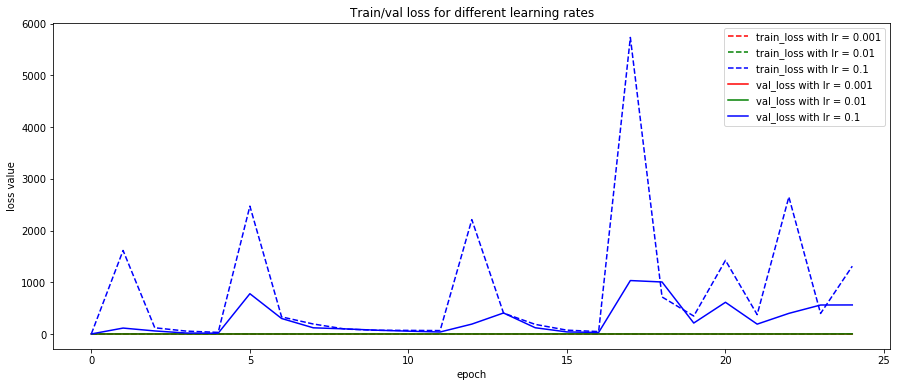

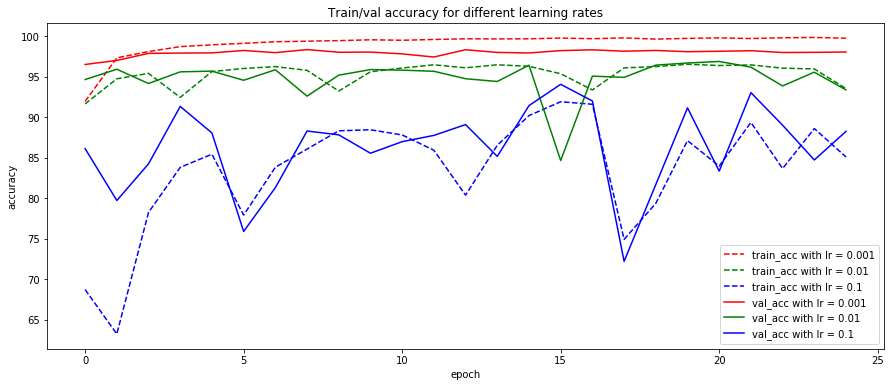

In [70]:
def plot(n_epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(15,6))
    
    legend_loss=[]
    
    colors=['r','g','b']
    
    i=0
    for learning_rate,train_loss in train_losses.items():
        plt.plot(np.arange(n_epochs), train_loss,f'{colors[i]}--')
        legend_loss.append(f'train_loss with lr = {learning_rate}')
        i+=1
        
    i=0
    for learning_rate,val_loss in val_losses.items():
        plt.plot(np.arange(n_epochs), val_loss,colors[i])
        legend_loss.append(f'val_loss with lr = {learning_rate}')
        i+=1
        
    plt.legend(legend_loss)
    
    plt.xlabel('epoch')
    plt.ylabel('loss value')
    plt.title('Train/val loss for different learning rates');

    plt.figure(figsize=(15,6))
    
    legend_acc=[]
    
    i=0
    for learning_rate,train_acc in train_accuracies.items():
        plt.plot(np.arange(n_epochs), train_acc,f'{colors[i]}--')
        legend_acc.append(f'train_acc with lr = {learning_rate}')
        i+=1
        
    i=0
    for learning_rate,val_acc in val_accuracies.items():
        plt.plot(np.arange(n_epochs), val_acc,colors[i])
        legend_acc.append(f'val_acc with lr = {learning_rate}')
        i+=1
    
    plt.legend(legend_acc)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Train/val accuracy for different learning rates');

plot(n_epochs, train_losses, val_losses, train_acc, val_acc)


In [81]:
print(f'The maximum accuracy with lr = 0.001 was achieved on epoch {val_acc[0.001].index(max(val_acc[0.001]))} with {max(val_acc[0.001])}% accuracy')

The maximum accuracy with lr = 0.001 was achieved on epoch 7 with 98.36% accuracy
